In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize
from datetime import date, timedelta



In [22]:
# Step 1: Data Collection
tickers = ['AAPL', 'GOOGL', 'AMZN', 'MSFT', 'TSLA']  # Example tickers
start_date = (date.today() - timedelta(days=365*5)).strftime("%Y-%m-%d")  # 5 years of data
end_date = date.today().strftime("%Y-%m-%d")

# Download data and check the available columns
data = yf.download(tickers, start=start_date, end=end_date)
print(data.columns) # Print available columns to check for 'Adj Close' or similar column names

# If 'Adj Close' is present, use it:
if 'Adj Close' in data.columns:
    data = data['Adj Close']
# Otherwise, try other possible column names like 'Close':
elif 'Close' in data.columns:
    data = data['Close']
    print("Using 'Close' column instead of 'Adj Close'")
else:
    raise KeyError("Neither 'Adj Close' nor 'Close' column found in the downloaded data.")


[*********************100%***********************]  5 of 5 completed

MultiIndex([( 'Close',  'AAPL'),
            ( 'Close',  'AMZN'),
            ( 'Close', 'GOOGL'),
            ( 'Close',  'MSFT'),
            ( 'Close',  'TSLA'),
            (  'High',  'AAPL'),
            (  'High',  'AMZN'),
            (  'High', 'GOOGL'),
            (  'High',  'MSFT'),
            (  'High',  'TSLA'),
            (   'Low',  'AAPL'),
            (   'Low',  'AMZN'),
            (   'Low', 'GOOGL'),
            (   'Low',  'MSFT'),
            (   'Low',  'TSLA'),
            (  'Open',  'AAPL'),
            (  'Open',  'AMZN'),
            (  'Open', 'GOOGL'),
            (  'Open',  'MSFT'),
            (  'Open',  'TSLA'),
            ('Volume',  'AAPL'),
            ('Volume',  'AMZN'),
            ('Volume', 'GOOGL'),
            ('Volume',  'MSFT'),
            ('Volume',  'TSLA')],
           names=['Price', 'Ticker'])
Using 'Close' column instead of 'Adj Close'


In [23]:
# Step 2: Data Preprocessing
returns = data.pct_change().dropna()

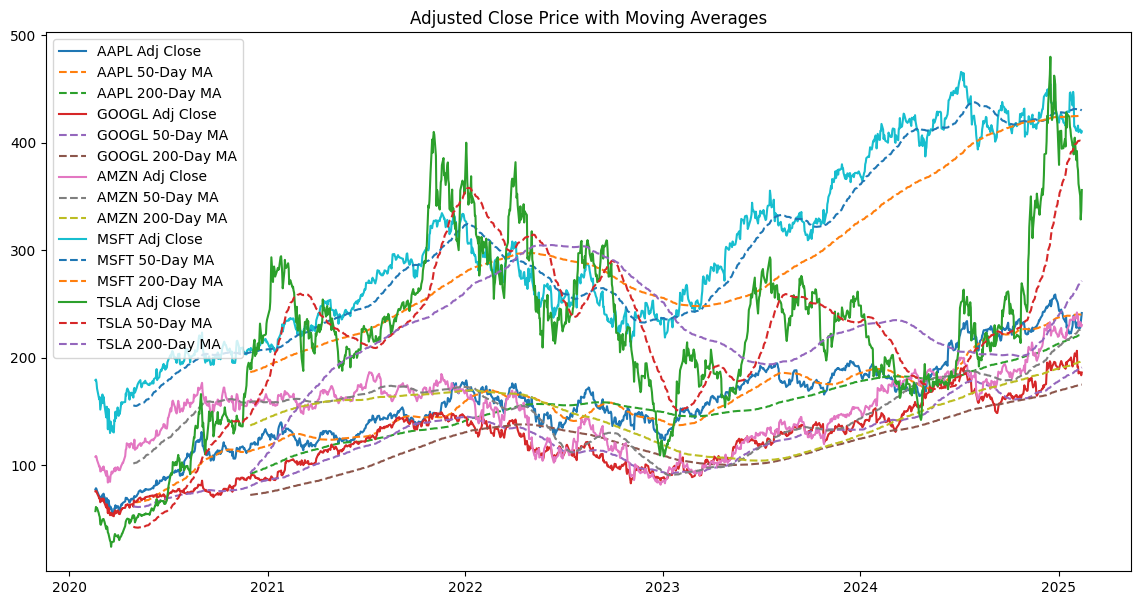

In [24]:
# Moving Averages for visualization
for ticker in tickers:
    data[ticker, '50_MA'] = data[ticker].rolling(window=50).mean()
    data[ticker, '200_MA'] = data[ticker].rolling(window=200).mean()

# Plot Adjusted Close Prices and Moving Averages
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(data.index, data[ticker], label=f'{ticker} Adj Close')
    plt.plot(data.index, data[ticker, '50_MA'], label=f'{ticker} 50-Day MA', linestyle='--')
    plt.plot(data.index, data[ticker, '200_MA'], label=f'{ticker} 200-Day MA', linestyle='--')
plt.title('Adjusted Close Price with Moving Averages')
plt.legend()
plt.show()

In [25]:
# Step 3: Portfolio Optimization with MPT
# Calculate expected returns and covariance matrix
mean_returns = returns.mean() * 252  # Annualize returns
cov_matrix = returns.cov() * 252  # Annualize covariance

In [26]:
# Portfolio Statistics Function
def portfolio_statistics(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

In [27]:
# Optimizing for Maximum Sharpe Ratio
def negative_sharpe_ratio(weights):
    portfolio_return, portfolio_volatility = portfolio_statistics(weights, mean_returns, cov_matrix)
    return -portfolio_return / portfolio_volatility

In [28]:
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 1) for asset in range(len(tickers)))
initial_weights = len(tickers) * [1. / len(tickers)]

In [29]:

# Use SLSQP optimizer to find optimal weights
result = minimize(negative_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = result.x

In [30]:

# Step 4: Machine Learning Models for Return Prediction (Random Forest Example)
X = returns.shift(1).dropna()  # Lagged returns as features
y = returns.iloc[1:]  # Next day's return

model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)
predictions = model.predict(X)

In [31]:
# Step 5: Risk Management (Monte Carlo Simulation)
def monte_carlo_simulation(initial_investment, n_simulations, n_days, mean_returns, cov_matrix, weights):
    simulation_results = np.zeros((n_simulations, n_days))
    for i in range(n_simulations):
        daily_returns = np.random.multivariate_normal(mean_returns, cov_matrix, n_days)
        portfolio_value = initial_investment
        for day_return in daily_returns:
            portfolio_value *= (1 + np.dot(day_return, weights))  # Multiply by daily returns
        simulation_results[i, :] = portfolio_value
    return simulation_results

In [32]:
simulations = monte_carlo_simulation(10000, 1000, 252, mean_returns, cov_matrix, optimal_weights)


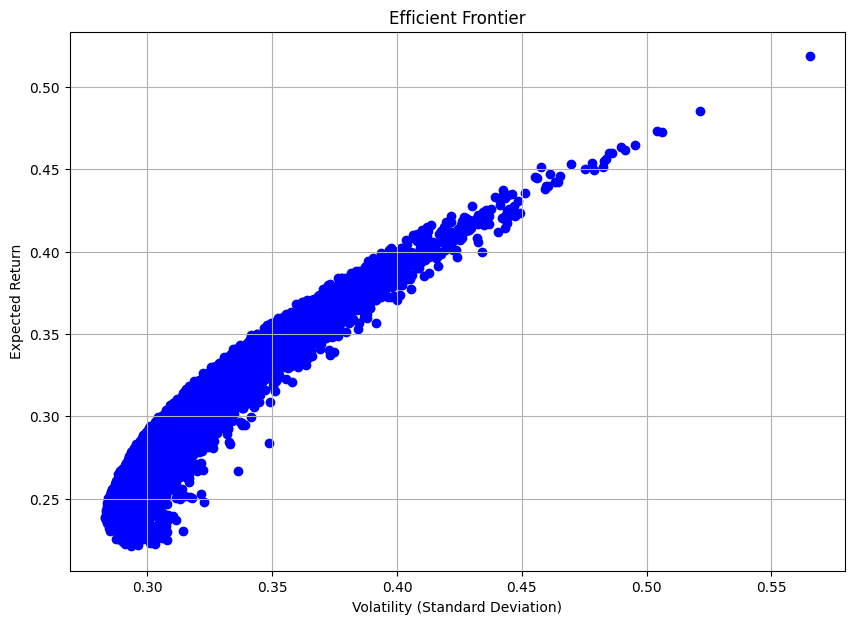

In [33]:
# Step 6: Visualizations

# Efficient Frontier
portfolio_volatility = []
portfolio_return = []
for _ in range(10000):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    ret, vol = portfolio_statistics(weights, mean_returns, cov_matrix)
    portfolio_return.append(ret)
    portfolio_volatility.append(vol)

plt.figure(figsize=(10, 7))
plt.scatter(portfolio_volatility, portfolio_return, c='blue', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.grid(True)
plt.show()

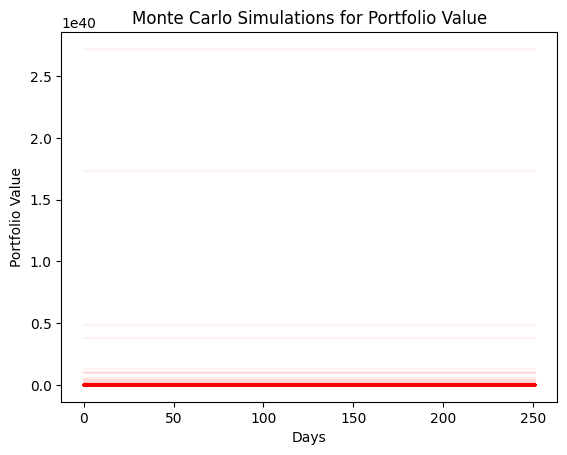

In [35]:
# Maximum Sharpe Ratio Portfolio Information
max_sharpe_idx = np.argmax([portfolio_return[i] / portfolio_volatility[i] for i in range(len(portfolio_return))])
max_sharpe_return = portfolio_return[max_sharpe_idx]
max_sharpe_volatility = portfolio_volatility[max_sharpe_idx]# Monte Carlo Simulations
plt.plot(simulations.T, 'r', alpha=0.05)
plt.title('Monte Carlo Simulations for Portfolio Value')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.show()

In [36]:
# Maximum Sharpe Ratio Portfolio Information
max_sharpe_idx = np.argmax([portfolio_return[i] / portfolio_volatility[i] for i in range(len(portfolio_return))])
max_sharpe_return = portfolio_return[max_sharpe_idx]
max_sharpe_volatility = portfolio_volatility[max_sharpe_idx]

print(f"Maximum Sharpe Ratio Portfolio:")
print(f"Expected Return: {max_sharpe_return*100:.2f}%")
print(f"Volatility: {max_sharpe_volatility*100:.2f}%")

Maximum Sharpe Ratio Portfolio:
Expected Return: 36.79%
Volatility: 35.97%


In [37]:
# Optimal Weights for Maximum Sharpe Ratio Portfolio
max_sharpe_weights = np.random.random(len(tickers))
max_sharpe_weights /= np.sum(max_sharpe_weights)
portfolio_weights_df = pd.DataFrame({'Ticker': tickers, 'Weight': max_sharpe_weights})
print(portfolio_weights_df)

  Ticker    Weight
0   AAPL  0.304151
1  GOOGL  0.122832
2   AMZN  0.236545
3   MSFT  0.175417
4   TSLA  0.161055
